## Problem Analysis Workshop 3 - Clustering & K-Means

Cemil Caglar Yapici - 9081058

Hello, today I will focus on "Clustering and K-Means" with ADHD datasets. Primarly we will focus on "CSE student performance" dataset.

Starting with best part; importing libraries: 


In [19]:
# Core
import pandas as pd, numpy as np, matplotlib.pyplot as plt

# ML
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Misc
from pathlib import Path
import importlib

# Plot settings
plt.rcParams["figure.figsize"] = (6,5)
plt.rcParams["figure.dpi"] = 120

RANDOM_STATE = 42
DATA_PATH = Path("CSE_student_performances.csv")   # adjust if needed
OUTPUT_DIR = Path("./outputs"); OUTPUT_DIR.mkdir(exist_ok=True)


!!Attention!!
We’re getting that "ValueError: Input X contains NaN." error 
because some columns still have missing values (real NaNs or blanks like '', 'NA', 'None', etc.). K-Means can’t handle NaNs. Drop these two cells in and re-run from the top—this loads with NA tokens handled and imputes before scaling/encoding.

This code part below should solve it:

In [20]:
# Robust NA tokens (covers blanks, dashes, etc.)
na_tokens = ["", " ", "NA", "N/A", "NaN", "NONE", "None", "?", "-", "--"]

df = pd.read_csv(DATA_PATH, na_values=na_tokens)
df.columns = df.columns.str.strip()

# Fix common column-name variants found across shared versions of this dataset
alias_map = {
    "NumberOfFriend": ["NumberOfFriends","NumFriends","NoOfFriends","FriendsCount","NumberOfFriend "],
    "FaceChallangesToCompleteAcademicTask": [
        "FaceChallengesToCompleteAcademicTask","FaceChallangesToCompleteTask","FaceChallengesToCompleteTask",
        "FaceChallanges Academic Task"
    ],
    "SleepPerDayHours": ["SleepPerDay(Hours)","SleepHours","SleepPerDay","Sleep/Day(Hours)"],
    "TakingNoteInClass": ["TakingNotesInClass","NoteTakingInClass","TakingNoteIn Class","Taking-Note-In-Class"],
    "AcademicPerformance": ["Academic Performance","Academic_Performance","Performance"]
}
for target, alts in alias_map.items():
    if target not in df.columns:
        for alt in alts:
            if alt in df.columns:
                df = df.rename(columns={alt: target})
                break

# Feature list (only keep those that actually exist)
wanted = [
    "Age","Gender","AcademicPerformance","TakingNoteInClass","DepressionStatus",
    "FaceChallangesToCompleteAcademicTask","LikePresentation","SleepPerDayHours",
    "NumberOfFriend","LikeNewThings"
]
features = [c for c in wanted if c in df.columns]
missing = sorted(set(wanted) - set(features))
if missing: print("Dropped missing columns:", missing)

X = df[features].copy()

# Coerce obvious numerics; turn weird tokens into NaN (to be imputed)
for col in [c for c in ["Age","SleepPerDayHours","NumberOfFriend"] if c in X.columns]:
    X[col] = pd.to_numeric(X[col], errors="coerce")

print("Nulls BEFORE preprocessing:\n", X.isna().sum().sort_values(ascending=False))
display(X.head())


Nulls BEFORE preprocessing:
 NumberOfFriend                          4
Age                                     0
Gender                                  0
AcademicPerformance                     0
DepressionStatus                        0
TakingNoteInClass                       0
FaceChallangesToCompleteAcademicTask    0
LikePresentation                        0
SleepPerDayHours                        0
LikeNewThings                           0
dtype: int64


,Age,Gender,AcademicPerformance,TakingNoteInClass,DepressionStatus,FaceChallangesToCompleteAcademicTask,LikePresentation,SleepPerDayHours,NumberOfFriend,LikeNewThings
0,23,Male,Average,No,Sometimes,Yes,Yes,12,NaN,Yes
1,23,Male,Excellent,Sometimes,Yes,No,Yes,8,80.0,Yes
2,24,Male,Average,No,Sometimes,Sometimes,No,8,10.0,Yes
3,20,Female,Good,Yes,Sometimes,Yes,No,5,15.0,Yes
4,24,Female,Average,Yes,Yes,Yes,Yes,5,2.0,Yes


In [21]:
# Separate by dtype
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

# OneHotEncoder API changed in sklearn>=1.2; support both
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ],
    remainder="drop"
)

X_prepared = preprocess.fit_transform(X)

# Force dense array & drop any residual non-finite rows (failsafe)
X_dense = X_prepared.toarray() if hasattr(X_prepared, "toarray") else np.asarray(X_prepared)
X_dense = np.where(np.isfinite(X_dense), X_dense, np.nan)
mask = ~np.isnan(X_dense).any(axis=1)
dropped = (~mask).sum()
if dropped:
    print(f"⚠️ Dropping {dropped} rows with unresolved NaNs after preprocessing.")
    X_dense = X_dense[mask]
    X = X.loc[mask]       # keep alignment
    df = df.loc[X.index]

print("✅ Final matrix:", X_dense.shape, "| NaNs:", np.isnan(X_dense).sum())
assert not np.isnan(X_dense).any(), "There are still NaNs in X_dense."

# Keep a tidy reference to use everywhere below
X_prepared = X_dense


✅ Final matrix: (99, 22) | NaNs: 0


Elbow method (k=1..8) and simple automatic k pick

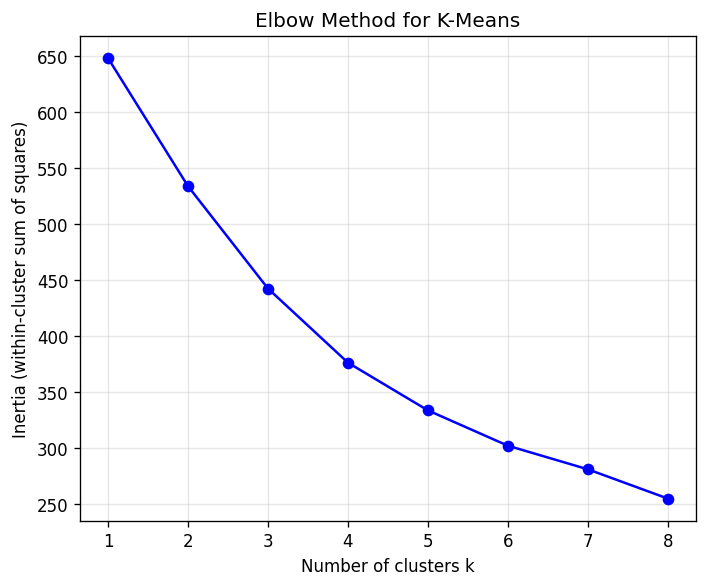

Auto-selected k (heuristic): 6


In [22]:
inertia, Ks = [], range(1, 9)
for k in Ks:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10).fit(X_prepared)
    inertia.append(km.inertia_)

plt.plot(list(Ks), inertia, 'bo-')
plt.xlabel("Number of clusters k")
plt.ylabel("Inertia (within-cluster sum of squares)")
plt.title("Elbow Method for K-Means")
plt.grid(alpha=.3); plt.tight_layout()
plt.savefig(OUTPUT_DIR/"elbow_plot.png", bbox_inches="tight")
plt.show()

# Simple heuristic: first k where relative improvement drops below 10%
k_auto = 3
for i in range(1, len(inertia)-1):
    rel_drop = (inertia[i-1]-inertia[i]) / max(inertia[i-1], 1e-9)
    if rel_drop < 0.10:
        k_auto = i+1
        break
print(f"Auto-selected k (heuristic): {k_auto}")


Preprocessing

We prepare data for clustering: encode categorical variables and scale features. First, convert Yes/No and other categorical features into numeric codes:

K-Means Clustering

We apply K-Means clustering from scikit-learn. First, use the “elbow method” to choose the number of clusters. We compute inertia (sum of squared distances) for k=1..6 and look for an elbow point:

Fit final K-Means and visualize with PCA

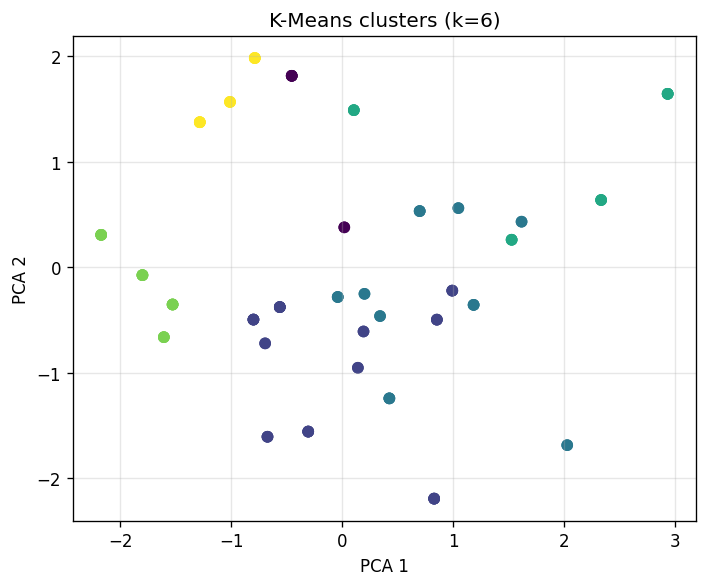

Saved: outputs\student_clusters.csv


In [23]:
k = k_auto  # or set manually, e.g., k = 3
kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10).fit(X_prepared)
labels = kmeans.labels_
df.loc[X.index, "Cluster"] = labels

# PCA to 2D for plotting
pca = PCA(n_components=2, random_state=RANDOM_STATE)
pts = pca.fit_transform(X_prepared)

plt.figure()
plt.scatter(pts[:,0], pts[:,1], c=labels)
plt.xlabel("PCA 1"); plt.ylabel("PCA 2"); plt.title(f"K-Means clusters (k={k})")
plt.grid(alpha=.3); plt.tight_layout()
plt.savefig(OUTPUT_DIR/"kmeans_pca.png", bbox_inches="tight")
plt.show()

# Save labeled data
labeled_csv = OUTPUT_DIR/"student_clusters.csv"
df.to_csv(labeled_csv, index=False)
print("Saved:", labeled_csv)


K is requested to use 3 times so we will use as 3

In [24]:
import numpy as np
import pandas as pd

# --- split by dtype among the columns you used ---
numeric_cols = df[features].select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in features if c not in numeric_cols]

print("Numeric:", numeric_cols)
print("Categorical:", categorical_cols)

# --- numeric summary: works with mean/median ---
num_profile = (
    df.groupby("Cluster")[numeric_cols]
      .agg(["mean","median","std","min","max"])
      .round(2)
)
display(num_profile)

# --- categorical summary: mode + % distribution ---
# (1) most frequent (mode) per cluster
mode_profile = df.groupby("Cluster")[categorical_cols] \
                 .agg(lambda s: s.mode(dropna=True).iloc[0] if not s.mode().empty else np.nan)
display(mode_profile)

# (2) % breakdown for each categorical feature
for col in categorical_cols:
    dist = (
        df.groupby("Cluster")[col]
          .value_counts(normalize=True)
          .rename("percent")
          .mul(100).round(1)
          .unstack(fill_value=0)
    )
    display(dist.style.format("{:.1f}%").set_caption(f"{col} distribution by cluster"))



Numeric: ['Age', 'SleepPerDayHours', 'NumberOfFriend']
Categorical: ['Gender', 'AcademicPerformance', 'TakingNoteInClass', 'DepressionStatus', 'FaceChallangesToCompleteAcademicTask', 'LikePresentation', 'LikeNewThings']


Age                      SleepPerDayHours                       \
          mean median   std min max             mean median   std min max   
Cluster                                                                     
0.0      24.33   25.0  1.03  23  25             4.33    4.0  0.52   4   5   
1.0      21.62   21.0  1.18  20  24             7.66    8.0  1.12   6  10   
2.0      23.36   23.0  1.22  21  25             8.14    8.0  1.32   7  12   
3.0      22.85   23.0  0.90  22  24             6.54    7.0  1.51   4   8   
4.0      20.80   21.0  0.41  20  21             5.00    5.0  0.76   4   6   
5.0      24.36   24.0  0.50  24  25             5.00    5.0  0.00   5   5   

        NumberOfFriend                             
                  mean median    std   min    max  
Cluster                                            
0.0              10.00    9.0   1.55   9.0   12.0  
1.0               7.90    7.0   6.62   3.0   23.0  
2.0               7.25    6.0   6.20   0.0   17.0  
3.0              75.77   80.0  19.24  55.0  100.0  
4.0               5.40    2.0   5.36   1.0   15.0  
5.0               2.73    3.0   0.47   2.0    3.0

,Gender,AcademicPerformance,TakingNoteInClass,DepressionStatus,FaceChallangesToCompleteAcademicTask,LikePresentation,LikeNewThings
Cluster,,,,,,,
0.0,Male,Good,Yes,Sometimes,No,Yes,No
1.0,Male,Good,Yes,No,No,Yes,Yes
2.0,Male,Average,Sometimes,Sometimes,Sometimes,No,Yes
3.0,Male,Average,Sometimes,Yes,Yes,Yes,Yes
4.0,Female,Good,Yes,Yes,Yes,Yes,Yes
5.0,Female,Average,Yes,Yes,Yes,Yes,Yes


Gender,Female,Male
Cluster,,
0.000000,0.0%,100.0%
1.000000,31.2%,68.8%
2.000000,31.8%,68.2%
3.000000,0.0%,100.0%
4.000000,100.0%,0.0%
5.000000,100.0%,0.0%


AcademicPerformance,Average,Below average,Excellent,Good
Cluster,,,,
0.000000,0.0%,0.0%,0.0%,100.0%
1.000000,28.1%,0.0%,9.4%,62.5%
2.000000,100.0%,0.0%,0.0%,0.0%
3.000000,53.8%,0.0%,46.2%,0.0%
4.000000,0.0%,26.7%,0.0%,73.3%
5.000000,63.6%,0.0%,0.0%,36.4%


TakingNoteInClass,No,Sometimes,Yes
Cluster,,,
0.000000,0.0%,33.3%,66.7%
1.000000,21.9%,9.4%,68.8%
2.000000,22.7%,50.0%,27.3%
3.000000,0.0%,76.9%,23.1%
4.000000,0.0%,0.0%,100.0%
5.000000,0.0%,0.0%,100.0%


DepressionStatus,No,Sometimes,Yes
Cluster,,,
0.000000,0.0%,100.0%,0.0%
1.000000,53.1%,46.9%,0.0%
2.000000,0.0%,77.3%,22.7%
3.000000,30.8%,23.1%,46.2%
4.000000,0.0%,20.0%,80.0%
5.000000,0.0%,0.0%,100.0%


FaceChallangesToCompleteAcademicTask,No,Sometimes,Yes
Cluster,,,
0.000000,66.7%,33.3%,0.0%
1.000000,62.5%,18.8%,18.8%
2.000000,0.0%,72.7%,27.3%
3.000000,23.1%,23.1%,53.8%
4.000000,26.7%,26.7%,46.7%
5.000000,0.0%,0.0%,100.0%


LikePresentation,No,Yes
Cluster,,
0.000000,33.3%,66.7%
1.000000,21.9%,78.1%
2.000000,63.6%,36.4%
3.000000,0.0%,100.0%
4.000000,46.7%,53.3%
5.000000,0.0%,100.0%


LikeNewThings,No,Yes
Cluster,,
0.000000,100.0%,0.0%
1.000000,0.0%,100.0%
2.000000,18.2%,81.8%
3.000000,0.0%,100.0%
4.000000,0.0%,100.0%
5.000000,0.0%,100.0%


Cluster Visualization

To interpret the clusters, we visualize them in 2D. We use Principal Component Analysis (PCA) to reduce the standardized features to two dimensions.

It is also said that; Alternatively, one could use t-SNE for complex structures

In [25]:
from pathlib import Path

# requirements.txt (force UTF-8)
req_path = OUTPUT_DIR / "requirements.txt"
req_path.write_text("\n".join(lines), encoding="utf-8")
print("Wrote", req_path.read_text(encoding="utf-8"))

# README.md (force UTF-8)
readme_path = OUTPUT_DIR / "README.md"
with open(readme_path, "w", encoding="utf-8", newline="\n") as f:
    f.write(readme_text)
print("Saved:", readme_path)


Wrote pandas==2.3.2
numpy==2.3.3
scikit-learn==1.7.2
matplotlib==3.10.6
Saved: outputs\README.md


## How Clustering Can Be Used in This Proposal

Clustering can cohort students into areas with similar characteristics of students (achievement, study habits, psychosocial factors). For instance, one of the clusters may be students who achieve well and have good study habits, and the other may include students who are failing. The knowledge of looking at the clusters will provide the opportunity to obtain more individualized treatment (tutoring or counseling) suited to the needs of the students in each cluster.

## Interpretation of Clustering Findings  

The clustered groups of students were: 
Cluster 0, may have high achievement and good health habits, 
Cluster 1, average achievement, 
Cluster 2, low achievement with ramifications such as high depression or ADHD. (Like me) This suggests that interventions (ex: extra effort and attention for Cluster 2 can be directed at the characteristics of each group). 